## Dataset Downloading

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle 

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"1e8e85d548f349b67f2e015da44880bd"}'}

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d nikhileswarkomati/suicide-watch

 93% 107M/115M [00:01<00:00, 61.1MB/s] 
100% 115M/115M [00:02<00:00, 59.9MB/s]


In [4]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/suicide-watch.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Libraries Import

In [4]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [6]:
#suppressing the warnings
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Reading The Data

In [7]:
dataset = pd.read_csv('/content/SuicideAndDepression_Detection.csv')
dataset.rename(columns={'text':'Text', 'class':'Class'}, inplace=True)
dataset.sample(5)

,Text,Class
268992,Fuck dude.I hate writing these because of all ...,SuicideWatch
182746,I've never heard of anybody feeling the way I ...,SuicideWatch
280046,"Tired of bottling everything up, nearly cut my...",depression
262778,Litany against Fear. I must not fear. \n ...,depression
117447,There is only two genders Shut the actual fuck...,teenagers


## Preparing The Data

In [8]:
dataset.loc[dataset['Class'] == 'teenagers','Class'] = 'Other'
dataset.loc[dataset['Class'] == 'depression','Class'] = 'Depression'
dataset.sample(5)

,Text,Class
133061,Fuck you.I'm done. Fuck you. You caused this. ...,SuicideWatch
306056,This YearHow one year can bring someone to rui...,SuicideWatch
103830,What does this mean??? I recently followed eve...,Other
661,I've been denied for a internship for the 5th ...,Depression
245602,Not sure how to ask for or accept help from my...,Depression


In [9]:
print(f'Size Of Dataset: {dataset.shape}')

Size Of Dataset: (348124, 2)


## Target Class Distribution

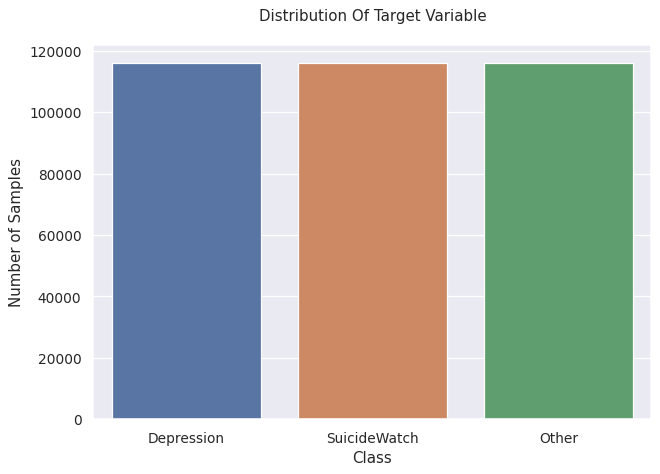

In [10]:
plt.rcParams['figure.figsize'] = [8,5.5]
plt.rcParams['figure.dpi'] = 90
sns.set(style='darkgrid')

sns.countplot('Class', data=dataset)
plt.ylabel("Number of Samples")
plt.title('Distribution Of Target Variable', pad=20)
plt.show()

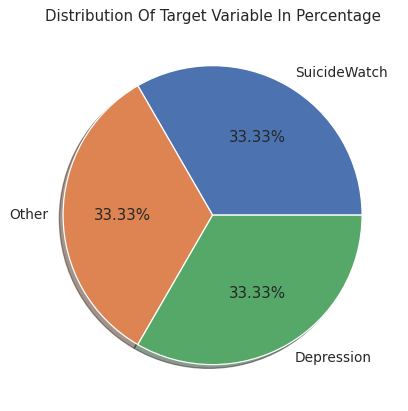

In [11]:
dataset['Class'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True)
plt.title('Distribution Of Target Variable In Percentage')
plt.ylabel("")
plt.show()

## Preparing The Data For visualization

In [12]:
def char_counts(x):
  #spliting the words
  s = x.split()
  #joining without space
  x = ''.join(x)
  return len(x)

In [13]:
#adding more information for exploratory data analysis
dataset['Word_Counts'] = dataset['Text'].apply(lambda x: len(str(x).split()))
dataset['Char_Counts'] = dataset['Text'].apply(lambda x: char_counts(str(x)))
dataset['Stop_Words_Count'] = dataset['Text'].apply(lambda x: len([word for word in str(x).split() if word in stopwords]))
dataset['Unique_Word_Count'] = dataset['Text'].apply(lambda x: len(set(str(x).split())))
dataset['Punctuation_Count'] = dataset['Text'].apply(lambda x: len([word for word in str(x) if word in string.punctuation]))

In [14]:
dataset.head(3)

,Text,Class,Word_Counts,Char_Counts,Stop_Words_Count,Unique_Word_Count,Punctuation_Count
0,Does life actually work for most / non-depress...,Depression,44,254,20,40,11
1,I found my friend's bodyIt was almost nine yea...,Depression,592,3009,280,310,97
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch,143,715,75,99,12


## Exploratory Data Analysis

In [15]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 95

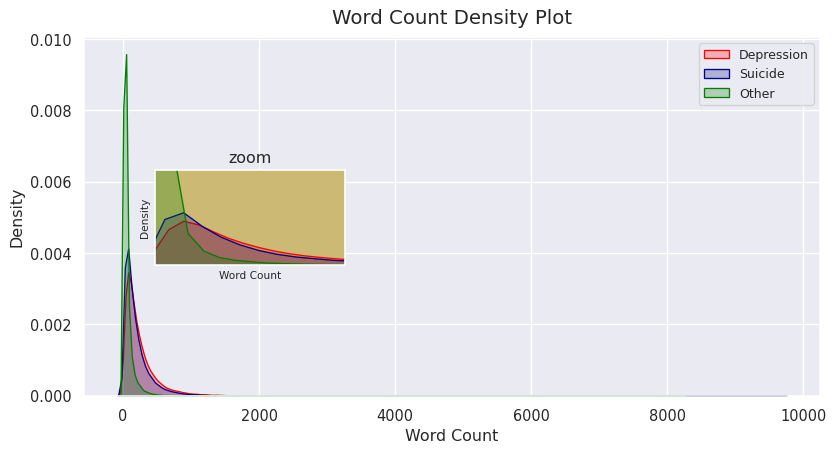

In [16]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Word_Counts'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Word_Counts'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Word_Counts'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Word Count')    
plt.title('Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Word_Counts'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Word_Counts'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Word_Counts'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.0075])
plt.show()

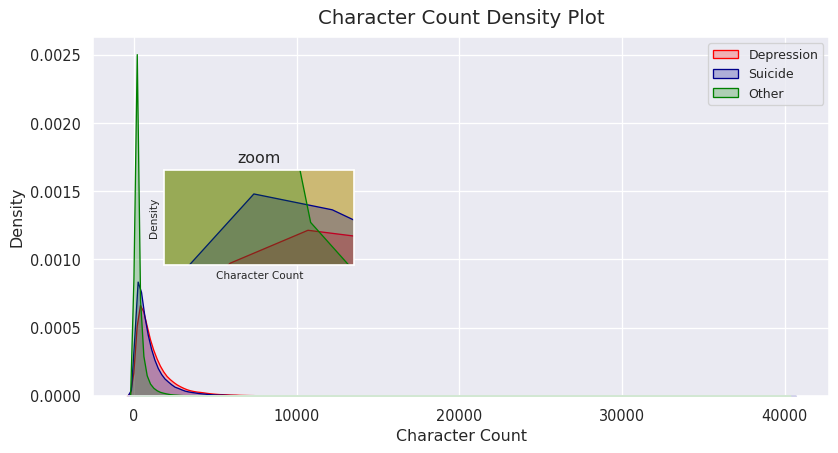

In [17]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Char_Counts'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Char_Counts'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Char_Counts'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Character Count')    
plt.title('Character Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Char_Counts'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Char_Counts'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Char_Counts'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Character Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0.0005,0.00095])
plt.show()

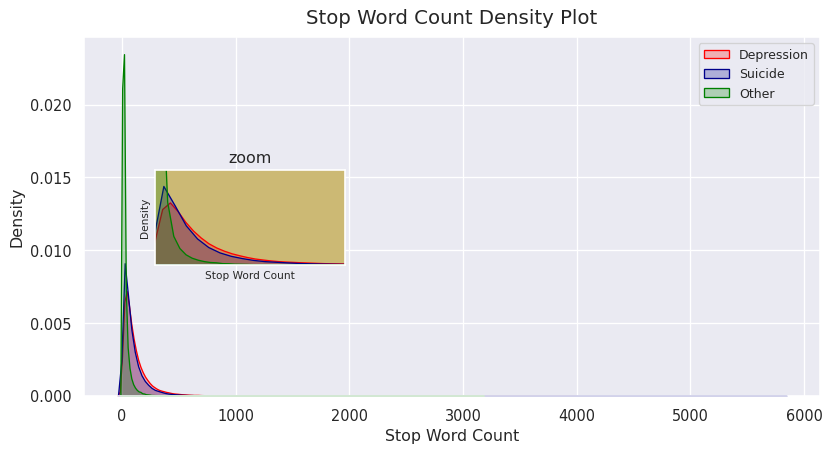

In [18]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Stop_Words_Count'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Stop_Words_Count'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Stop_Words_Count'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Stop Word Count')    
plt.title('Stop Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Stop_Words_Count'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Stop_Words_Count'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Stop_Words_Count'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Stop Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.011])
plt.show()

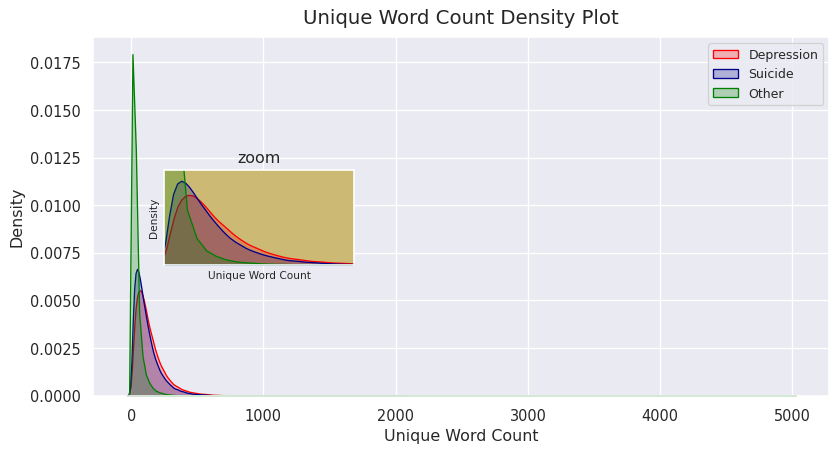

In [19]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Unique_Word_Count'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Unique_Word_Count'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Unique_Word_Count'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Unique Word Count')    
plt.title('Unique Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Unique_Word_Count'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Unique_Word_Count'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Unique_Word_Count'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Unique Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.0075])
plt.show()

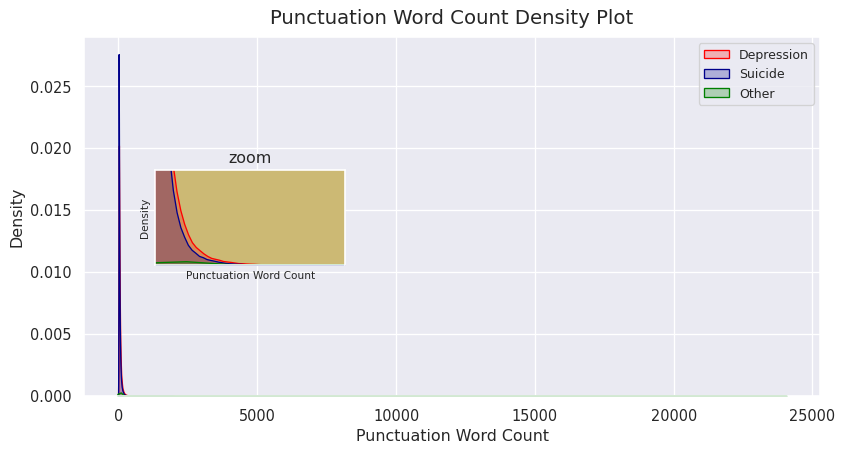

In [20]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Punctuation_Count'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Punctuation_Count'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Punctuation_Count'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Punctuation Word Count')    
plt.title('Punctuation Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Punctuation_Count'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Punctuation_Count'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Punctuation_Count'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Punctuation Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.0075])
plt.show()

## Cleaning The Text Data

In [21]:
!pip -q install contractions
import contractions
import unicodedata

In [22]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [23]:
#for removal of frequent and raer words
freq_comm = pd.Series(dataset['Text']).value_counts()
f20 = freq_comm[:50]
rare20 = freq_comm.tail(50)

In [24]:
def get_clean(X):
  X = str(X).lower()
  X = X.replace('\\', ' ').replace('_', ' ').replace('.', ' ').replace(':', '')
  X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
  X = re.sub(r'\brt\b', '', X).strip()
  X = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',"", X)
  X = re.sub(r'[^\w\d\s]+','', X)
  X = ' '.join(X.split())
  X = BeautifulSoup(X, 'lxml').get_text().strip()
  X = remove_accented(X)
  X = re.sub(r'[^\w ]+','',X)
  X = re.sub("(.)\\1{2,}", "\\1", X)
  X = contractions.fix(X)
  #X = ' '.join([word for word  in X.split() if word not in stopwords])
  X = ' '.join([word for word in X.split() if word not in f20]) 
  X = ' '.join([word for word in X.split() if word not in rare20])
  return X

In [25]:
dataset['Text'] = dataset['Text'].apply(lambda X : get_clean(X))
dataset = dataset[dataset['Text'].str.split().str.len().ge(3)]

In [26]:
dataset.sample(4)

,Text,Class,Word_Counts,Char_Counts,Stop_Words_Count,Unique_Word_Count,Punctuation_Count
64005,why does it get worse when things get better i...,Depression,191,951,94,125,25
11735,how do get a how do i get the age flair how,Other,12,47,6,9,0
147880,everything is better with cute girls even i wo...,Other,38,191,16,36,2
102627,not now but soon ill be dead by 26 or 27 24 no...,SuicideWatch,403,2130,165,236,93


## Word Cloud Representation

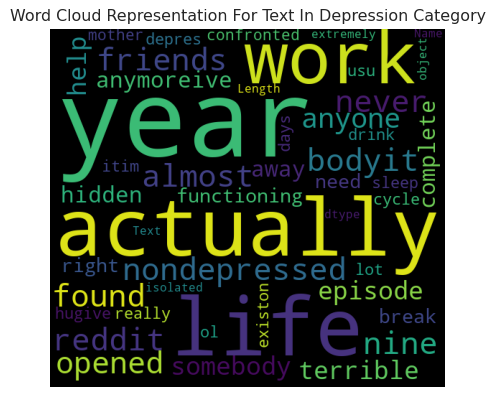

In [30]:
toxic = str(dataset[dataset['Class']=='Depression'].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Text In Depression Category')
plt.axis('off')
plt.show()

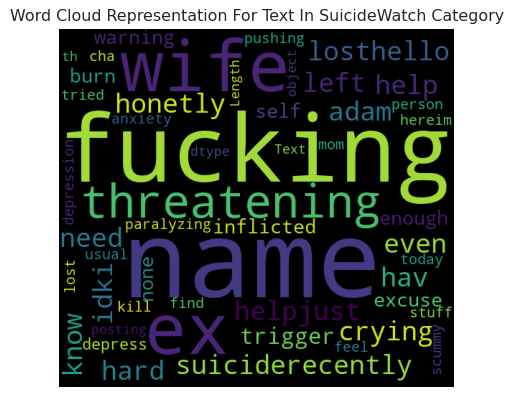

In [33]:
toxic = str(dataset[dataset['Class']=='SuicideWatch'].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Text In SuicideWatch Category')
plt.axis('off')
plt.show()

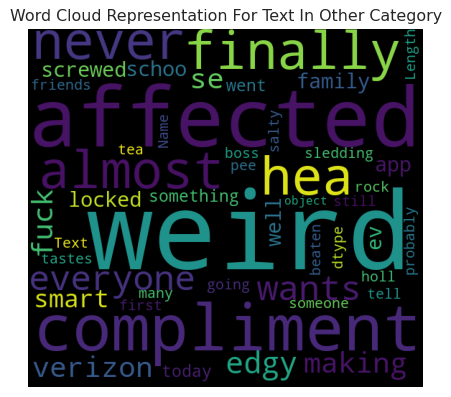

In [29]:
toxic = str(dataset[dataset['Class']=='Other'].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Text In Other Category')
plt.axis('off')
plt.show()

## Data Preparation For Training & Testing

In [34]:
X = dataset['Text']

In [35]:
Y_df = dataset['Class']
Y_df = pd.DataFrame({'Class':Y_df.values})
Y_df['Class'] = Y_df.Class.astype('category')
Y_df['Label_Code'] = Y_df["Class"].cat.codes
display(Y_df.sample(5))
#{Depression:0, Other:1 ,SuicideWatch:2}

,Class,Label_Code
81802,SuicideWatch,2
212929,Depression,0
13019,Other,1
66922,Other,1
274767,Depression,0


In [36]:
Y = to_categorical(Y_df['Label_Code'])
Y = pd.DataFrame({'Depression': Y[:, 0], 'SuicideWatch': Y[:, 1], 'Other': Y[:, 2]})
display(Y.sample(4))

,Depression,SuicideWatch,Other
48307,0.0,1.0,0.0
121954,0.0,0.0,1.0
125879,0.0,0.0,1.0
39459,0.0,1.0,0.0


## Converting Text Data Into Machine Understandable Numeric Data

In [37]:
#Tokenization
token = Tokenizer()
token.fit_on_texts(X)

In [38]:
vocab_size = len(token.word_index) + 1
print('The size of vocab:', vocab_size)

The size of vocab: 288283


In [39]:
encoded_text = token.texts_to_sequences(X)
max_length = len(X.max()) + 5  
X = pad_sequences(encoded_text, maxlen=max_length, padding='pre')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0, stratify=Y)

In [41]:
print(f'Shape of train Dataset: {X_train.shape, y_train.shape}')
print(f'Shape of test Dataset: {X_test.shape, y_test.shape}')

Shape of train Dataset: ((208708, 458), (208708, 3))
Shape of test Dataset: ((139139, 458), (139139, 3))


## Model Creation

In [42]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(70, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(140, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(3, activation='softmax'))

## Understanding The Model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 458, 100)          28828300  
_________________________________________________________________
conv1d (Conv1D)              (None, 457, 70)           14070     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 228, 70)           0         
_________________________________________________________________
dropout (Dropout)            (None, 228, 70)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 227, 140)          19740     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 113, 140)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 113, 140)          0

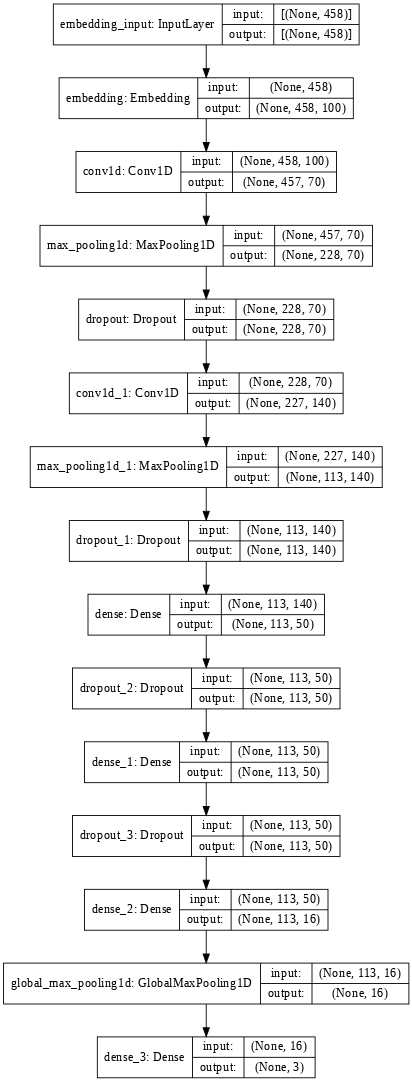

In [44]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

## Model Training Phase

In [45]:
#optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer= SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
r = model.fit(X_train, y_train, epochs=150, batch_size=150, validation_data=(X_test, y_test))

Epoch 1/150
1392/1392 [==============================] - 71s 48ms/step - loss: 1.0820 - accuracy: 0.4060 - val_loss: 1.1008 - val_accuracy: 0.3331
Epoch 2/150
1392/1392 [==============================] - 66s 48ms/step - loss: 0.9462 - accuracy: 0.5162 - val_loss: 1.1706 - val_accuracy: 0.3451
Epoch 3/150
1392/1392 [==============================] - 66s 48ms/step - loss: 0.9122 - accuracy: 0.5304 - val_loss: 1.1429 - val_accuracy: 0.3447
Epoch 4/150
1392/1392 [==============================] - 66s 48ms/step - loss: 0.8946 - accuracy: 0.5335 - val_loss: 1.0346 - val_accuracy: 0.4159
Epoch 5/150
1392/1392 [==============================] - 66s 48ms/step - loss: 0.8501 - accuracy: 0.5592 - val_loss: 0.8387 - val_accuracy: 0.5983
Epoch 6/150
1392/1392 [==============================] - 66s 48ms/step - loss: 0.8017 - accuracy: 0.6005 - val_loss: 0.8003 - val_accuracy: 0.6318
Epoch 7/150
1392/1392 [==============================] - 66s 48ms/step - loss: 0.7799 - accuracy: 0.6181 - val_loss: 0

## Model Accuracy

In [50]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The validation accuracy of model is {math.floor(r.history["val_accuracy"][-1] * 100)} %')

The traning accuracy of model is 86 %
The validation accuracy of model is 76 %


## Model Loss

In [51]:
print(f'The traning loss of model is {r.history["loss"][-1]:.4}')
print(f'The validation loss of model is {r.history["val_loss"][-1]:.4}')
#need more training

The traning loss of model is 0.3288
The validation loss of model is 0.5705


In [52]:
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = [20,7]

## Model Loss Visualization

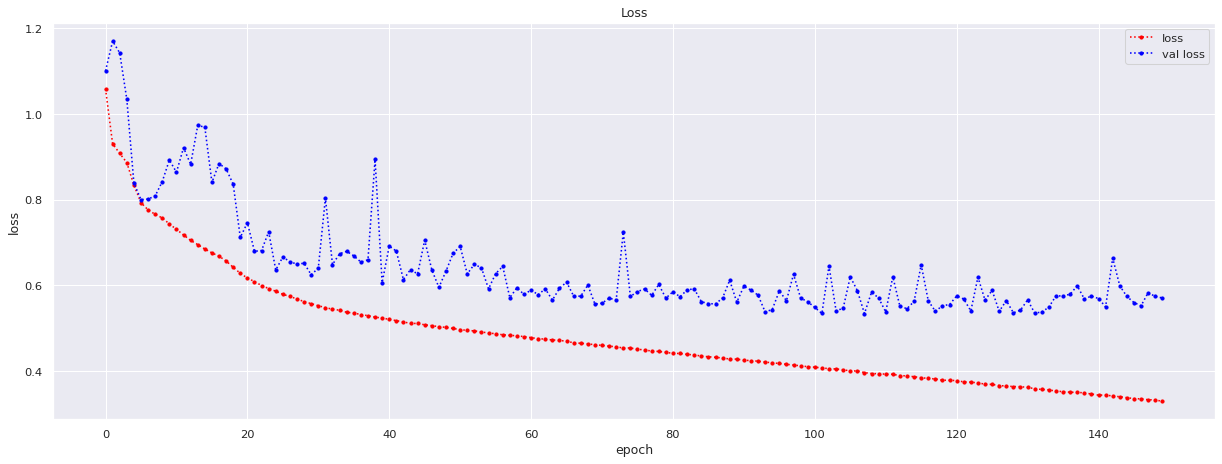

In [56]:
plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='loss', linewidth=1.5, color="red")
plt.plot(r.history['val_loss'], ".:", label='val loss', linewidth=1.5, color="blue")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Accuracy Visualization

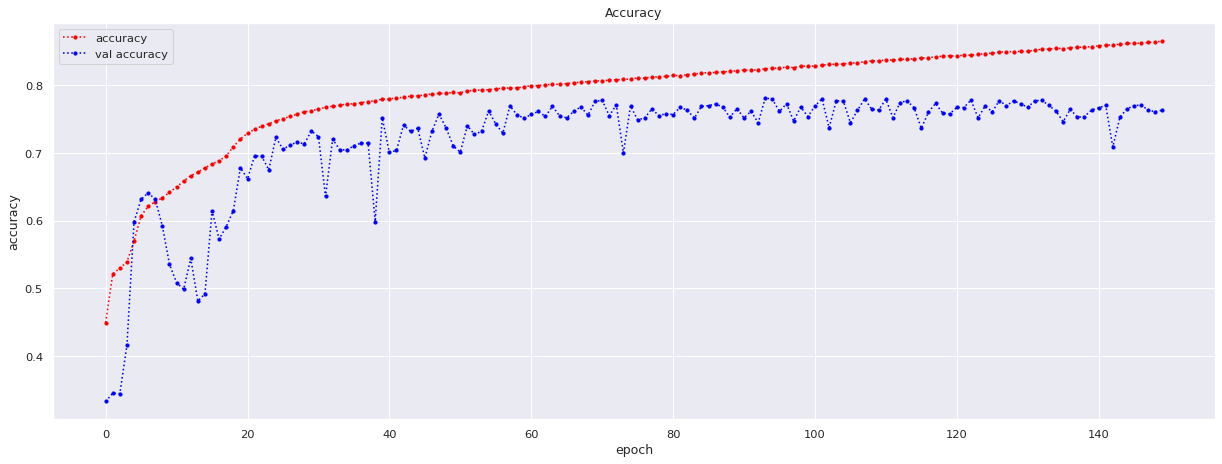

In [57]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="red")
plt.plot(r.history['val_accuracy'], ".:", label='val accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Testing The Model On Custom Data

In [58]:
classes = ['Depression', 'Other', 'SuicideWatch']
# {Depression:0, Other:1 ,SuicideWatch:2}

In [59]:
text = "I'm felling hopless and sad I have lost my way and don't know what do."

In [60]:
text = get_clean(text)
en_text = encoded_text = token.texts_to_sequences(text)
en_text = pad_sequences(en_text, maxlen=max_length, padding='pre')

In [61]:
x = get_clean(text)
x = encoded_text = token.texts_to_sequences(x)
x = pad_sequences(x, maxlen=max_length, padding='pre')
y_pred = np.argmax(model.predict_classes(x))

In [62]:
print(f'Sentence: {text}')
print(f'Result: Model has found symptoms of {classes[y_pred]} in the above sentence.')

Sentence: I am felling hopless and sad i have lost my way and do not know what do
Result: Model has found symptoms of Depression in the above sentence.
